# IA006 - Aprendizado de Máquina 
## EFC 2 - Classificadores Lineares

### Alunos 
* Daniel Rodrigues Silveira Freitas - 145782
* João Carlos Cerqueira - 146611

## Parte 2 - Classificador Binário

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)

In [3]:
class LDA():
    
    def __init__(self):
        self.w = None # Not used
    
    def means(self, df, num_classes):
        
        cl = np.array([])
        
        for i in range(num_classes):
            for j in range(num_classes):
                cl = np.append(cl, df[df['y'] == i].iloc[:,j].mean())
                
        return cl.reshape(num_classes,num_classes)
        
                
    def in_class_matrix(self, df, mean):
        
        M = np.zeros((int(df.iloc[:,0].count()/2), 4)) # Assuming same amount of data for each class
        S_w = np.array([])
        
        for i,m in zip(range(2),range(0,3,2)):
            M[:, m:m+2] = df[df['y'] == i].iloc[:,:2] - mean[:,i] # Rows where x1 and x2 lead to a specific class

        for m in range(4):
            S_w = np.append(S_w, np.sum(np.dot(M[:,m:m+1],M[:,m:m+1].T)))

        return S_w.reshape(2,2)
        
    def max_w(self, S_w, mean):
        
        mv = (mean[0,:] - mean[1,:]).reshape(2,1) # mean(x1,x2) class 1 - mean(x1,x2) class 2
        w = np.dot(np.linalg.inv(S_w), mv) 
        
        # Normalize w
        w = w/math.sqrt(w[0] ** 2 + w[1] ** 2)
        
        return w
    
    def fit(self, df, w):
        sns.scatterplot(x='x_1',
                y='x_2',
                data=df,
                hue="y",
                palette='Set2'
                );
        ax = plt.axes();
        x = np.linspace(-1.5, 1 , 1000)
        if w is not None:
            y = x * w[0]/w[1]
            ax.plot(x, y)
        plt.show()
        
    def projection(self, df, w):
        
        c = pd.DataFrame()

        c_x1 = df[df['y'] == 0].iloc[:,0:2].T
        c_x2 = df[df['y'] == 1].iloc[:,0:2].T
        w = w.reshape(1,2)

        c_1 = np.dot(w, c_x1)
        c_2 = np.dot(w, c_x2)

        c['c_1'] = c_1.reshape(500)
        c['c_2'] = c_2.reshape(500)
        
        return c
    
    def histogram(self, c):
        
        plt.hist(c.c_1, bins=20, alpha=0.5, label='y = 0')
        plt.hist(c.c_2, bins=20, alpha=0.5, label='y = 1')
        plt.legend(loc='upper right')
        
    def ROC(self, m):
        threshold = [x / 100  for x in range(-200, 200, 5)]
        tp_rate, fp_rate = [],[]
        tp, fp, fn, tn = 0,0,0,0

        for th in threshold:
            for i in range(len(m.c_1)):
                if(m.c_1[i] < th):
                    tp += 1
                else:
                    fn += 1

            for i in range(len(m.c_2)):
                if(m.c_2[i] < th):
                    fp += 1
                else:
                    tn += 1   
            tp_rate.append(tp/(tp + fn))
            fp_rate.append(fp/(tn + fp))
            tp, fp, fn, tn = 0,0,0,0
        
        return tp_rate, fp_rate
    
    def F1(self, m):
        threshold = [x / 100 for x in range(-200, 200, 5)]
        f1 = []
        recall, precision = 0, 1
        tp, fp, fn, tn = 0, 0, 0, 0

        for th in threshold:
            for i in range(len(m.c_1)):
                if(m.c_1[i] < th):
                    tp += 1
                else:
                    fn += 1

            for i in range(len(m.c_2)):
                if(m.c_2[i] < th):
                    fp += 1
                else:
                    tn += 1   
            try:
                recall = (tp/(tp + fn))
                precision = (tp/(tp + fp))
            except:
                pass
            f1.append( 2 * ( ( recall * precision ) / ( recall + precision)))
            tp, fp, fn, tn = 0,0,0,0
        
        return threshold[f1.index(max(f1))], f1

### Visualização das observações

In [4]:
df = pd.read_csv("../data/two_moons.csv")

In [5]:
df = df.iloc[:,1:4] # Remove useless column of data
df.describe()

,x_1,x_2,y
count,1000.000000,1000.000000,1000.00000
mean,0.501832,0.448112,0.50000
std,0.880995,0.682659,0.50025
min,-1.278076,-0.868250,0.00000
25%,-0.082646,-0.196449,0.00000
50%,0.500967,0.441311,0.50000
75%,1.098231,1.075139,1.00000
max,2.327938,1.802177,1.00000


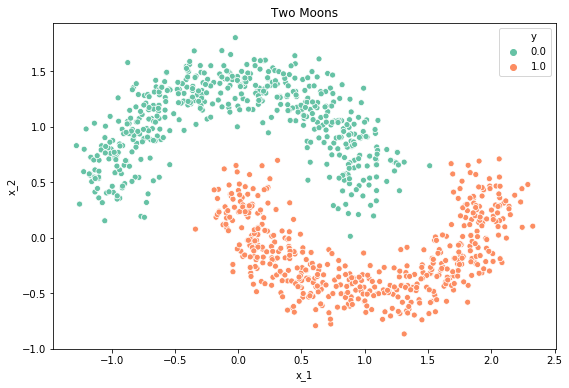

In [6]:
lda = LDA()
plt.title("Two Moons");
lda.fit(df,w=None)

#### Comentário
A visualização dos dados permite inferir que, a fim de resolver o problema de classificação binária do dataset TwoMoons, um simples discriminante linear não levaria ao grau de complexidade necessário. Isso se dá pelo fato de que uma reta não seria suficiente para separar os dois conjuntos, que aparecem em formato de duas luas (de onde advém o nome do conjunto de dados). Pode-se notar com certa facilidade que, independentemente da projeção ótima de um Discriminante Linear de Fischer, ainda assim haveria sobreposição de classes, o que ocasionaria em erro de decisão.  Na próxima etapa essa hipótese será verificada em termos práticos.

### LDA e Discriminante de Fischer

Em seguida, será utilizada a técnica de obtenção do Discriminante Linear de Fischer ou LDA (Linear discriminant analysis). A ideia dessa abordagem é fazer uma classificação das observações através da redução da dimensionalidade do espaço dos dados. É uma categoria de classificação no âmbito supervisionado e que se baseia em encontrar a reta (para o caso de duas variáveis) que melhor mapeia as distribuições de modo a :

1. Aumentar o espalhamento inter-classes
2. Diminuir o espalhamento intra-classe

No gráfico abaixo tem-se a projeção ótima do Discriminante Linear de Fischer junto aos dados.


 Mean vector: 
 [[-0.00174703  1.03675024]
 [ 1.00541181 -0.14052539]]
S_w: 
 [[  2.84217094e-14   2.45524287e+02]
 [  2.45524287e+02   7.10542736e-15]]

 W: 
 [[ 0.75987325]
 [-0.65007126]]


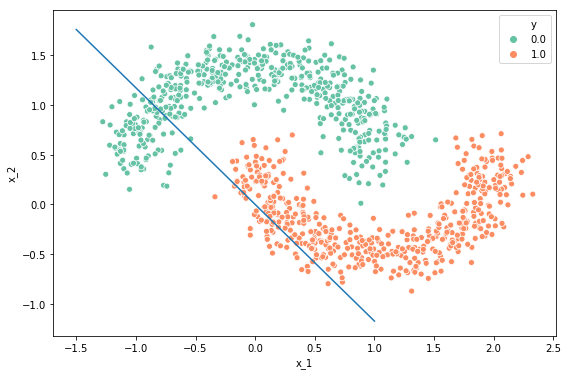

In [7]:
mv = lda.means(df ,2) # Means of both x_1 and x_2
S_w = lda.in_class_matrix(df,mv) # Covariance matrix
w = lda.max_w(S_w, mv) # Optimal projection for the dataset
print("\n Mean vector: \n",mv)
print("S_w: \n",S_w)
print("\n W: \n",w)
lda.fit(df,w=w)

Como um próximo passo, pode-se visualizar os histogramas das observações já projetados na reta de projeção ótima.

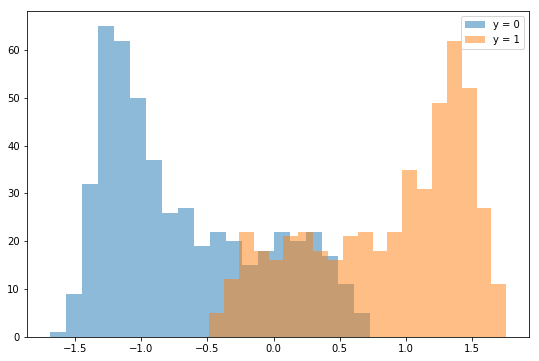

In [8]:
m = lda.projection(df,w)
lda.histogram(m)

#### Comentário
De acordo com o histograma dos dados na projeção ótima do Discriminante Linear de Fischer, pode-se verificar que o comportamento desejado pela técnica é obtido, pois as classes de fato estão separáveis, de uma maneira que as médias entre as observações se distanciam mas ao mesmo tempo os pontos intra-classe estão suficientementes agrupados.

Em seguida, deve-se definir como será a decisão sobre quais pontos são pertencentes à quais classes. Essa etapa pode ser feita de inúmeras maneiras. Em primeiro lugar, é feita uma busca linear variando-se os valores que definem o limiar entre uma classe e outra. Sendo assim, classes que são apontadas à esquerda do limiar são pertencentes à primeira classe e, caso o contrário, pertencentes à segunda classe. Ao se fazer a comparação entre os dados classificados e os rótulos propriamente ditos, tem-se quantitativamente como eles foram classificados. Se foram gerados falso positivo, falso negativos, verdadeiro positivos ou verdadeiro negativos. Com essas informações obtém-se a curva denominada ROC (Receiver Operating Curve) a qual, quanto mais à esquerda estiver e mais para cima, melhor. Essa métrica é interessante quando se deseja fazer uma comparação entre modelos. Aquele que obtiver maior área sob a curva ROC deve ser o melhor classificador.  

Abaixo está a curva ROC para o Discriminante Linear de Fischer projetado

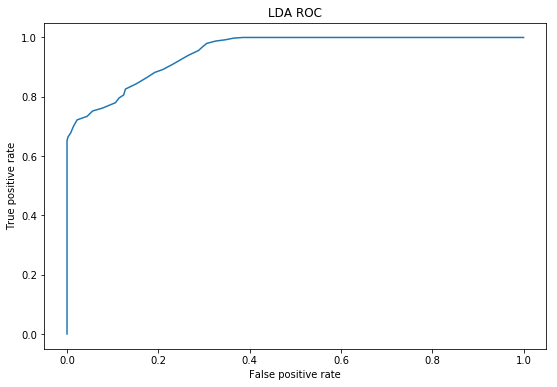

In [9]:
tp_rate_lda, fp_rate_lda = lda.ROC(m)
plt.plot(fp_rate_lda,tp_rate_lda);
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.title("LDA ROC");

Para identificar qual o melhor limiar para a separação entre as classes, é utilizada a métrica denominada F-medida. Essa métrica avalia a relação entre recall e precisão através de uma média harmônica ponderada. Se for dada o mesmo nível de importância para ambos (precisão e recall) tem-se a F1 medida:

$$ F1 = 2\frac{recall(y') * precisão(y')}{recall(y') + precisão(y')}$$

In [10]:
best_th, f1 = lda.F1(m)
print("Melhor valor de Threshold para a Regressão Logística:", best_th)

Melhor valor de Threshold para a Regressão Logística: 0.55


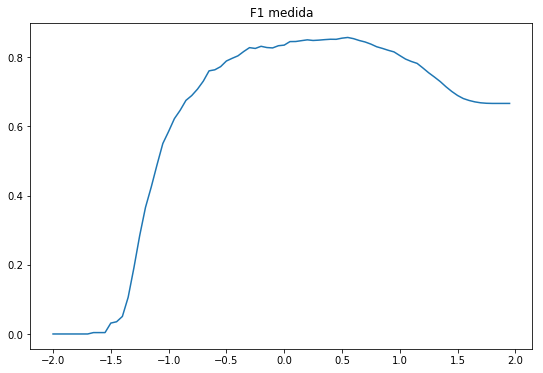

In [11]:
threshold = [x / 100 for x in range(-200, 200, 5)]
plt.plot(threshold, f1);
plt.title("F1 medida");

Sendo assim, o ponto máximo da curva F1, ou o valor mais próximo de 1 nos dá o valor de threshold que obteve melhores resultados tanto em recall quanto em precisão. Se colocarmos uma reta no valor obtido como melhor threshold tem-se a figura abaixo.

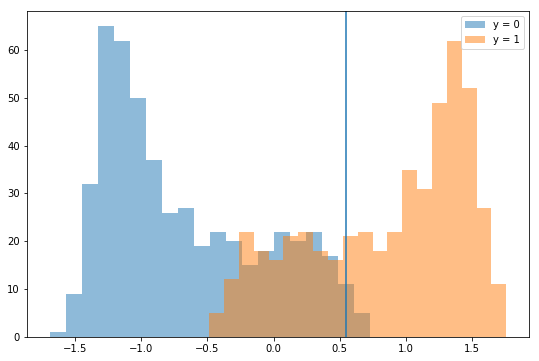

In [12]:
lda.histogram(m)
plt.axvline(x=best_th);

### Regressão Logística

A Regressão Logística é um algoritmo que também pode ser utilizado para o problema de classificação binária. O intuito agora é verificar os resultados de um modelo de Regressão Logística para o conjunto de dados "two moons" e em seguida comparar com o que foi obtido no LDA utilizado anteriormente.

In [13]:
class LogisticRegression():
    
    def __init__(self):
        self.w = np.random.randn(3) # initialize weights
    
    def regression(self, df):
        y_pred = 1 / (1 + np.exp(-(np.dot(df.iloc[:,0:3], self.w))))
        
        return y_pred
    
    def weights_update(self, learning_rate, grad_J):
        w_n = self.w - learning_rate * grad_J
        
        return w_n
    
    def grad_descent(self, df, y_pred):
    
        N = df.shape[0]
        phi = df.iloc[:,:3]
        y = df.iloc[:,3]
        y_p = y_pred[:]
        
        e = y - y_p

        grad_J = (-1/N) * np.dot(e.T, phi)     
        
        return grad_J
    
    def fit(self, df, learning_rate, batchs, epochs):
        
        batch_size = int(len(df)/batchs)
        # mini-batch
        for epoch in range(epochs):
            for batch in range(0, len(train_df), batch_size):

                y_pred = self.regression(train_df.iloc[batch:batch + batch_size,:])
                J = self.grad_descent(train_df.iloc[batch:batch + batch_size,:], y_pred)
                self.w = self.weights_update(learning_rate, J)

        
    def predict(self, test_df):
        return self.regression(test_df)
    
    def ROC(self, y_pred, y):

        threshold = [x/1000 for x in range(0, 1001, 5)]
        tp_rate, fp_rate = [],[]
        tp, fp, fn, tn = 0,0,0,0

        for th in threshold:
            for i in range(len(y)):
                if (y_pred[i] < th):
                    if (y[i] == 0):
                        tp += 1
                    else:
                        fp += 1
                else:
                    if (y[i] == 0):
                        fn += 1
                    else:    
                        tn += 1

            tp_rate.append(tp/(tp + fn))
            fp_rate.append(fp/(tn + fp))
            tp, fp, fn, tn = 0,0,0,0

        return tp_rate, fp_rate
    
    def F1(self, y_pred, y):
        
        threshold = [x/1000 for x in range(0, 1001, 5)]
        f1 = []
        tp, fp, fn, tn = 0, 0, 0, 0
        
        for th in threshold:
            for i in range(len(y)):
                if (y_pred[i] < th):
                    if (y[i] == 0):
                        tp += 1
                    else:
                        fp += 1
                else:
                    if (y[i] == 0):
                        fn += 1
                    else:    
                        tn += 1
            if (( tp + fn) > 0 and (tp + fp) > 0):
                recall = (tp/(tp + fn))
                precision = (tp/(tp + fp))
                f1.append( 2 * ( ( recall * precision ) / ( recall + precision)))
            tp, fp, fn, tn = 0,0,0,0
            
        return threshold[f1.index(max(f1))], f1
               
class CrossValidation():
    
    def __init__(self):
        
        pass
    
    def holdout_split(self, df, train_pct):
        
        tr = int(len(df) * train_pct)
        train = df.iloc[:tr,:]
        test = df.iloc[tr:,:]
        
        return train, test
        

#### Preparação dos dados 

A construção do algoritmo de regressão logística sugere que seja criada uma entrada de bias em conjunto com os dados:

In [14]:
# Insert bias column
try:
    df.insert(0, 'b', 1)
except:
    print("Bias column probably already inserted")
    pass

#### Validação Cruzada

Para fazer a avaliação posterior dos resultados do modelo, foi escolhida uma abordagem no estilo validação cruzada do tipo *Holdout*, o qual simplesmente separa o conjunto de dados em teste e treino. A tentativa é de se utilizar blocos contíguos de dados. 

In [15]:
cv = CrossValidation()
train_df, test_df = cv.holdout_split(df, train_pct=0.8)

#### Treino da Regressão
Como o problema de Regressão Logística não possui solução analítica, é necessário fazer inúmeras iterações para que o que for suficientemente bom seja atingido, ou seja, para que a função custo encontre o mínimo global. Sendo assim, a escolha foi de fazer treinamento baseado em *mini-batch* e épocas e gradiente descendente para a atualização dos pesos sinápticos. Os hiperparâmetros que constituem o tamanho do *minibatch*, número de épocas, taxa de aprendizado foram arbitrários e não foi feita uma verificação minunciosa com finalidade de encontrar quais seriam os melhores, em outras palavras, não foi feito um *fine tunning* de hiperparâmetros. Acredita-se que esse não é o enfoque do notebook.

In [16]:
lr = LogisticRegression()
lr.fit(train_df, learning_rate=0.5, batchs=100, epochs=100)

#### Avaliação dos Resultados

Após construído e treinado o modelo, é o momento de se fazer a verificação dos resultados obtidos frente ao conjunto de dados de teste. Dessa forma, são escolhidas duas métricas, assim como foi feito para o caso do LDA. São elas a curva ROC e F1-medida. 

In [17]:
y_pred = lr.predict(test_df)
y = test_df.y.reset_index(drop=True)
tp_rate, fp_rate = lr.ROC(y_pred, y)

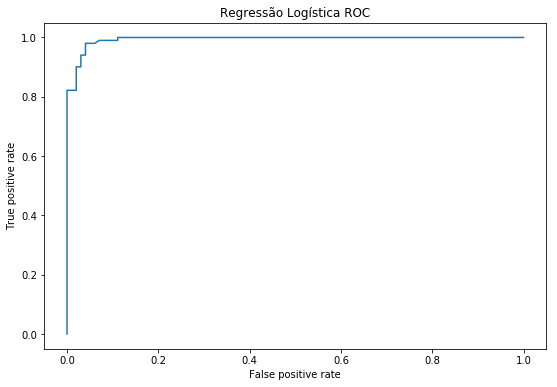

In [18]:
plt.plot(fp_rate,tp_rate);
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.title("Regressão Logística ROC");

#### Comentários

A figura abaixo mostra as curvas ROC tanto para a Regressão Logística quanto para o LDA. Curva ROC é indicada para fazer avaliação comparativa entre modelos utilizando como base a área abaixo da curva. Sendo assim, é fácil notar que o modelo de Regressão Logística supera o LDA no que se refere à capacidade de generalização do modelo, ou seja, é um modelo mais adequado para o tipo de problema enfrentado.

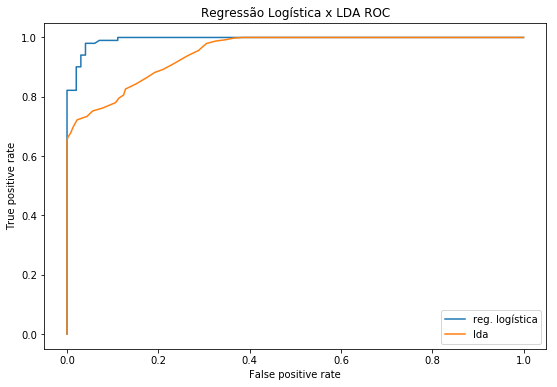

In [19]:
plt.plot(fp_rate,tp_rate, label='reg. logística');
plt.plot(fp_rate_lda,tp_rate_lda, label ='lda');
plt.legend()
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.title("Regressão Logística x LDA ROC");

#### F1 Medida
A F1-medida, como já comentado, é utilizada para verificar em que ponto obtém-se melhor desempenho do classificador quanto à fronteira de separação entre as classes.


In [20]:
best_th, f1 = lr.F1(y_pred, y)
print("Melhor valor de Threshold para a Regressão Logística:", best_th)

Melhor valor de Threshold para a Regressão Logística: 0.745


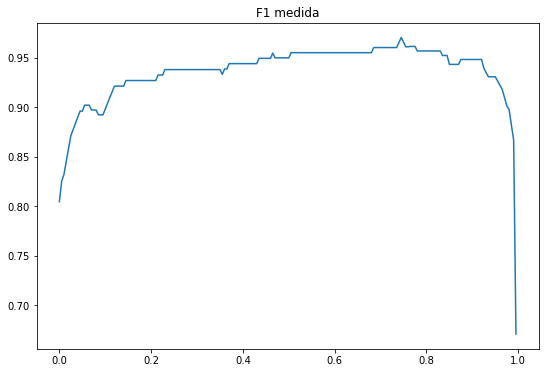

In [21]:
threshold = [x/1000 for x in range(0, 1000, 5)]
plt.plot(threshold, f1);
plt.title("F1 medida");

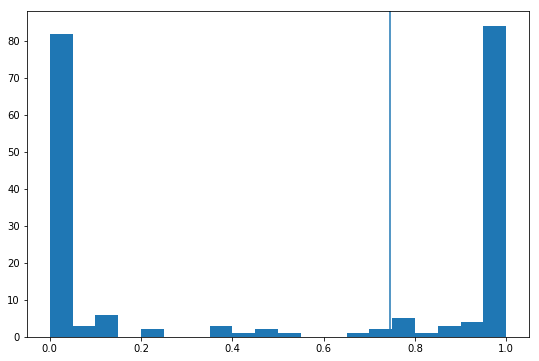

In [22]:
a = pd.DataFrame()
a['y_pred'] = y_pred
#a.hist()
plt.hist(a.values, bins=20)
plt.axvline(x=best_th);

#### Comentários
Verifica-se que a F1-medida para o caso de Regressão Logística tem um valor levemente inferior ao do LDA (se considerarmos os valores normalizados entre 0 e 1). Isso pode ser interpretado pelo fato da Regressão Logística não atribuir muitos valores intermediários na hora da predição, jogando os valores em sua maioria pra 0 ou pra 1, que são de fato os alvos da predição. Dessa forma, as classes já estão suficientemente bem separadas, o que não acontece com tanta facilidade no caso do LDA.